[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/camenduru/flux-jupyter/blob/main/flux.1-dev_jupyter.ipynb)

In [5]:
# !git clone -b totoro3 https://github.com/camenduru/ComfyUI TotoroUI
# %cd TotoroUI

!pip install -q torchsde einops diffusers accelerate pickleshare transformers torchvision xformers==0.0.28.post2
!sudo apt -y install -qq aria2

# !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/flux1-dev-fp8.safetensors -d models/unet -o flux1-dev-fp8.safetensors
# !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/ae.sft -d models/vae -o ae.sft
# !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/clip_l.safetensors -d models/clip -o clip_l.safetensors
# !aria2c --console-log-level=error -c -x 16 -s 16 -k 1M https://huggingface.co/camenduru/FLUX.1-dev/resolve/main/t5xxl_fp8_e4m3fn.safetensors -d models/clip -o t5xxl_fp8_e4m3fn.safetensors

import random
import torch
import numpy as np
from PIL import Image
import nodes
from nodes import NODE_CLASS_MAPPINGS
from totoro_extras import nodes_custom_sampler
from totoro import model_management

DualCLIPLoader = NODE_CLASS_MAPPINGS["DualCLIPLoader"]()
UNETLoader = NODE_CLASS_MAPPINGS["UNETLoader"]()
RandomNoise = nodes_custom_sampler.NODE_CLASS_MAPPINGS["RandomNoise"]()
BasicGuider = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicGuider"]()
KSamplerSelect = nodes_custom_sampler.NODE_CLASS_MAPPINGS["KSamplerSelect"]()
BasicScheduler = nodes_custom_sampler.NODE_CLASS_MAPPINGS["BasicScheduler"]()
SamplerCustomAdvanced = nodes_custom_sampler.NODE_CLASS_MAPPINGS["SamplerCustomAdvanced"]()
VAELoader = NODE_CLASS_MAPPINGS["VAELoader"]()
VAEDecode = NODE_CLASS_MAPPINGS["VAEDecode"]()
EmptyLatentImage = NODE_CLASS_MAPPINGS["EmptyLatentImage"]()

with torch.inference_mode():
    clip = DualCLIPLoader.load_clip("t5xxl_fp8_e4m3fn.safetensors", "clip_l.safetensors", "flux")[0]
    unet = UNETLoader.load_unet("flux1-dev-fp8.safetensors", "fp8_e4m3fn")[0]
    vae = VAELoader.load_vae("ae.sft")[0]

def closestNumber(n, m):
    q = int(n / m)
    n1 = m * q
    if (n * m) > 0:
        n2 = m * (q + 1)
    else:
        n2 = m * (q - 1)
    if abs(n - n1) < abs(n - n2):
        return n1
    return n2


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 53 not upgraded.


clip missing: ['text_projection.weight']
model_type FLUX
Using xformers attention in VAE
Using xformers attention in VAE


Requested to load FluxClipModel_
Loading 1 new model
loading in lowvram mode 1991.1628904342651


10230951261056681485


Requested to load Flux
Loading 1 new model
loading in lowvram mode 564.3978900909424


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencodingEngine
Loading 1 new model
/tmp/ipykernel_2887/590880222.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("flux.png")
/tmp/ipykernel_2887/590880222.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])


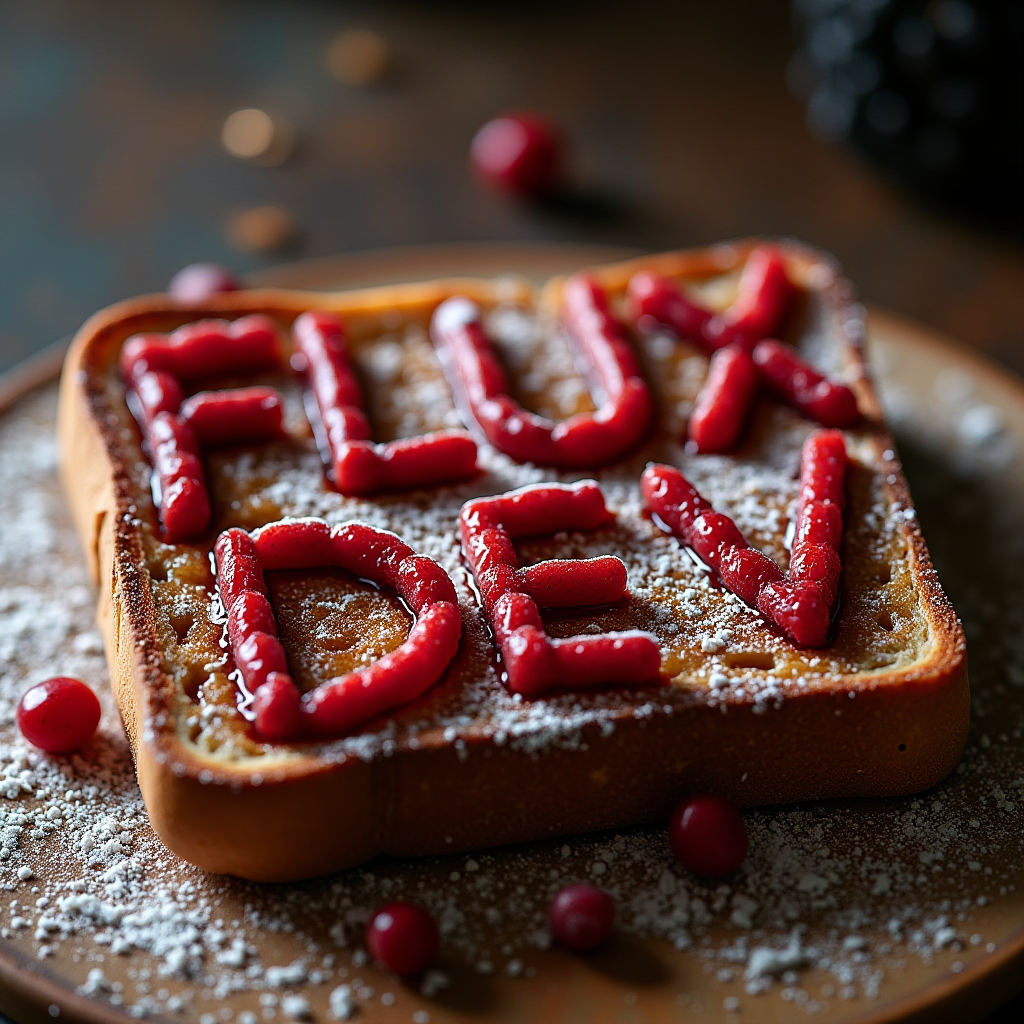

In [6]:
with torch.inference_mode():
    positive_prompt = "black forest toast spelling out the words 'FLUX DEV', tasty, food photography, dynamic shot"
    width = 1024
    height = 1024
    seed = 0
    steps = 20
    sampler_name = "euler"
    scheduler = "simple"

    if seed == 0:
        seed = random.randint(0, 18446744073709551615)
    print(seed)

    cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
    cond = [[cond, {"pooled_output": pooled}]]
    noise = RandomNoise.get_noise(seed)[0] 
    guider = BasicGuider.get_guider(unet, cond)[0]
    sampler = KSamplerSelect.get_sampler(sampler_name)[0]
    sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
    latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
    sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
    model_management.soft_empty_cache()
    decoded = VAEDecode.decode(vae, sample)[0].detach()
    Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0]).save("flux.png")

Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])

Generating 256 x 256 image from prompt: A colorful cartoon of a round central portal containing a happy Humpback Whale with its mouth open
Seed  8070787920866585132


Requested to load Flux
Loading 1 new model
loading in lowvram mode 1955.0378904342651


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencodingEngine
Loading 1 new model
/tmp/ipykernel_2887/324727046.py:26: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  return Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])


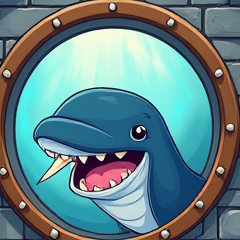

Requested to load FluxClipModel_
Loading 1 new model
loading in lowvram mode 1955.0378904342651


Saved to Humpback Whale.jpg
Generating 256 x 256 image from prompt: A colorful cartoon of a round central portal containing a happy Wolf with its mouth open
Seed  6096905986972859220


Requested to load Flux
Loading 1 new model
loading in lowvram mode 1955.0378904342651


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencodingEngine
Loading 1 new model


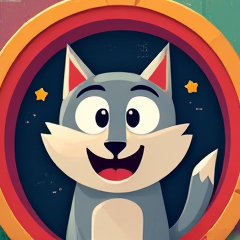

Requested to load FluxClipModel_
Loading 1 new model
loading in lowvram mode 1955.0378904342651


Saved to Wolf.jpg
Generating 256 x 256 image from prompt: A colorful cartoon of a round central portal containing a happy Dolphin with its mouth open
Seed  5165613908293751539


Requested to load Flux
Loading 1 new model
loading in lowvram mode 1955.0378904342651


  0%|          | 0/20 [00:00<?, ?it/s]

Requested to load AutoencodingEngine
Loading 1 new model


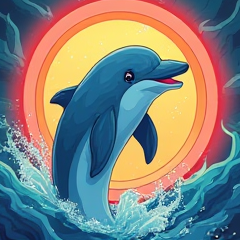

Requested to load FluxClipModel_
Loading 1 new model
loading in lowvram mode 1955.0378904342651


Saved to Dolphin.jpg
Generating 256 x 256 image from prompt: A colorful cartoon of a round central portal containing a happy Howler Monkey with its mouth open
Seed  8123632044493275750


In [ ]:
def gen_image(width:int , height:int, prompt:str) -> Image:
    print(f"Generating {width} x {height} image from prompt: {prompt}")
    with torch.inference_mode():
        positive_prompt = prompt
        width = width
        height = height
        seed = 0
        steps = 20
        sampler_name = "euler"
        scheduler = "simple"
    
        if seed == 0:
            seed = random.randint(0, 18446744073709551615)
        print("Seed ", seed)
    
        cond, pooled = clip.encode_from_tokens(clip.tokenize(positive_prompt), return_pooled=True)
        cond = [[cond, {"pooled_output": pooled}]]
        noise = RandomNoise.get_noise(seed)[0] 
        guider = BasicGuider.get_guider(unet, cond)[0]
        sampler = KSamplerSelect.get_sampler(sampler_name)[0]
        sigmas = BasicScheduler.get_sigmas(unet, scheduler, steps, 1.0)[0]
        latent_image = EmptyLatentImage.generate(closestNumber(width, 16), closestNumber(height, 16))[0]
        sample, sample_denoised = SamplerCustomAdvanced.sample(noise, guider, sampler, sigmas, latent_image)
        model_management.soft_empty_cache()
        decoded = VAEDecode.decode(vae, sample)[0].detach()
        return Image.fromarray(np.array(decoded*255, dtype=np.uint8)[0])


def crop_center_and_save(img: Image, output_filename: str) -> None:
    if img.size != (256, 256):
        raise ValueError("Input image must be 256x256 pixels.")

    # Define the coordinates of the central 240x240 region
    left = (256 - 240) // 2
    top = (256 - 240) // 2
    right = left + 240
    bottom = top + 240

    # Crop the central 240x240 region
    cropped_img = img.crop((left, top, right, bottom))

    # Save the cropped image as a JPEG
    cropped_img.save(output_filename, "JPEG")
    
    display(cropped_img)    
    print(f"Saved to {output_filename}")


for animal in [
    "Humpback Whale",
    "Wolf",
    "Dolphin",
    "Howler Monkey",
    "Kookaburra",
    "Elephant",
    "Lyrebird",
    "Cicada",
    "Peacock",
    "Owl",
    "Koala",
    "Bullfrog",
    "Hyena",
    "Parrot",
    "Coyote",
    "Bat",
    "Alligator",
    "Maned Wolf",
    "Donkey",
    "Seal",
    "Rattlesnake",
    "Tree Frog",
    "Goose",
    "Puffin",
    "Emperor Penguin",
    "Fox",
    "Beluga Whale",
    "Sperm Whale",
    "Great Horned Owl",
    "Gibbon",
    "Vervet Monkey",
    "Capuchin Monkey",
    "Chickadee",
    "Nightingale",
    "Cicada",
    "Cuckoo",
    "Beaver",
    "Woodpecker",
    "Red Fox",
    "Loon",
    "Mourning Dove",
    "Cockatoo",
    "Raven",
    "Tarsier",
    "Leopard Seal",
    "Tawny Owl",
    "Bald Eagle",
    "Elk",
    "Peregrine Falcon",
    "Zebra"
  ]:
    img = gen_image(256, 256, f"A colorful cartoon of a round central portal containing a happy {animal} with its mouth open")    
    crop_center_and_save(img, f"{animal}.jpg")
    